## Installation

In [6]:
# import the pytorch library into environment and check its version
import torch
print("Using torch", torch.__version__)

# check if GPU is available and detectable. cpu is ok for this homework.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using torch 2.5.1+cu121
Using device: cuda


In [2]:
import torch

!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb  # for datasets

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-t0thhtlf
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-t0thhtlf
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 1519e9fa9cd0d23ee7b64d80563a45b10599a0c6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1168624 sha256=916fbe26fec4fb3027831242a4fba005379608d97012b8a1865edd96b3e20ca1
  Stored in directory: /tmp/pip-ephem-wheel-cache-4qz3pg_3/wheels/d3/78/eb/9e26525b948d19533f1688fb6c209cec8a0ba793d39b49ae8f
Successfully built torch-geometric
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.3 MB/s eta 0:00:00


In [23]:
import pickle

'''
clique_structure = {2: {('Grass', 'Wing'): {'Landbird': 34, 'Waterbird': 9},
  ('People', 'Wing'): {'Landbird': 10, 'Waterbird': 17},
  ('Bamboo', 'Forest'): {'Landbird': 384, 'Waterbird': 5},
  ('Beach', 'Man'): {'Landbird': 2, 'Waterbird': 26},
  ...
'''
with open('/content/clique_dict_final_urbancars.pkl', 'rb') as f:
    clique_structure = pickle.load(f)

In [68]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from itertools import combinations
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# Assumes `clique_structure` is defined externally

# 1. Convert clique structure to graph Data object
unique_nodes = set()
for k, cliques in clique_structure.items():
    for nodes_tuple in cliques.keys():
        for node in nodes_tuple:
            unique_nodes.add(node)

node2idx = {node: i for i, node in enumerate(unique_nodes)}

edge_index_list = []
edge_attr_list = []

def add_edges_from_clique(nodes, attr):
    (u, v) = nodes
    u_idx = node2idx[u]
    v_idx = node2idx[v]
    edge_index_list.append([u_idx, v_idx])
    edge_attr_list.append([attr['urban'], attr['country']])
    # Undirected edge
    edge_index_list.append([v_idx, u_idx])
    edge_attr_list.append([attr['urban'], attr['country']])

for clique_size, cliques in clique_structure.items():
    for nodes, attr in cliques.items():
        add_edges_from_clique(nodes, attr)

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

num_nodes = len(unique_nodes)
x = torch.randn((num_nodes, 16))  # random features as placeholder
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 2. Define models
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class EdgePredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, in_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(in_channels, 1)
        )

    def forward(self, z, edge_index):
        z_u = z[edge_index[0]]
        z_v = z[edge_index[1]]
        out = self.mlp(torch.cat([z_u, z_v], dim=-1))
        return out.view(-1)

# 3. Train/val/test split
all_edges = edge_index.t().tolist()
unique_edges = list(set((min(u,v), max(u,v)) for u,v in all_edges if u!=v))
random.shuffle(unique_edges)

num_train = int(len(unique_edges)*0.8)
num_val = int(len(unique_edges)*0.1)

train_edges = unique_edges[:num_train]
val_edges = unique_edges[num_train:num_train+num_val]
test_edges = unique_edges[num_train+num_val:]

def to_tensor(edges):
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

train_edges = to_tensor(train_edges)
val_edges = to_tensor(val_edges)
test_edges = to_tensor(test_edges)

def negative_sampling(num_samples, num_nodes, existing_set):
    neg_edges = []
    while len(neg_edges) < num_samples:
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if u != v:
            e = (min(u,v), max(u,v))
            if e not in existing_set:
                neg_edges.append([u,v])
                existing_set.add(e)
    return torch.tensor(neg_edges, dtype=torch.long).t().contiguous()

train_set = set((min(a,b), max(a,b)) for a,b in train_edges.t().tolist())
val_set = set((min(a,b), max(a,b)) for a,b in val_edges.t().tolist())
test_set = set((min(a,b), max(a,b)) for a,b in test_edges.t().tolist())

train_neg = negative_sampling(train_edges.size(1), num_nodes, train_set)
val_neg = negative_sampling(val_edges.size(1), num_nodes, val_set)
test_neg = negative_sampling(test_edges.size(1), num_nodes, test_set)

# 4. Training setup with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GNNEncoder(in_channels=16, hidden_channels=32, out_channels=16, dropout=0.5).to(device)
predictor = EdgePredictor(16).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(predictor.parameters()),
    lr=0.001, weight_decay=1e-4
)
criterion = torch.nn.BCEWithLogitsLoss()

data = data.to(device)
train_edges = train_edges.to(device)
val_edges = val_edges.to(device)
test_edges = test_edges.to(device)
train_neg = train_neg.to(device)
val_neg = val_neg.to(device)
test_neg = test_neg.to(device)

def get_loss(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index)
    neg_score = predictor(z, neg_edge_index)
    scores = torch.cat([pos_score, neg_score], dim=0)
    labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))], dim=0).to(device)
    return criterion(scores, labels)

def get_metrics(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index).sigmoid().detach().cpu().numpy()
    neg_score = predictor(z, neg_edge_index).sigmoid().detach().cpu().numpy()
    scores = list(pos_score) + list(neg_score)
    labels = [1]*len(pos_score) + [0]*len(neg_score)
    auc = roc_auc_score(labels, scores)
    # Accuracy at threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

best_val_loss = float('inf')
patience_counter = 0
patience = 20
max_epochs = 500

for epoch in range(max_epochs):
    encoder.train()
    predictor.train()
    optimizer.zero_grad()
    z = encoder(data.x, data.edge_index)
    loss = get_loss(z, predictor, train_edges, train_neg)
    loss.backward()
    optimizer.step()

    encoder.eval()
    predictor.eval()
    with torch.no_grad():
        z = encoder(data.x, data.edge_index)
        val_loss = get_loss(z, predictor, val_edges, val_neg).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_encoder_weights = encoder.state_dict()
        best_predictor_weights = predictor.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.4f}, Val Loss {val_loss:.4f}")

# Load best weights
encoder.load_state_dict(best_encoder_weights)
predictor.load_state_dict(best_predictor_weights)
encoder.eval()
predictor.eval()

with torch.no_grad():
    z = encoder(data.x, data.edge_index)
    test_auc, test_acc = get_metrics(z, predictor, test_edges, test_neg)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 0: Train Loss 0.7036, Val Loss 0.7041
Epoch 10: Train Loss 0.6972, Val Loss 0.6983
Epoch 20: Train Loss 0.6922, Val Loss 0.6939
Epoch 30: Train Loss 0.6890, Val Loss 0.6920
Epoch 40: Train Loss 0.6878, Val Loss 0.6879
Epoch 50: Train Loss 0.6832, Val Loss 0.6827
Epoch 60: Train Loss 0.6723, Val Loss 0.6761
Epoch 70: Train Loss 0.6590, Val Loss 0.6637
Epoch 80: Train Loss 0.6431, Val Loss 0.6427
Epoch 90: Train Loss 0.5915, Val Loss 0.6092
Epoch 100: Train Loss 0.5611, Val Loss 0.5649
Epoch 110: Train Loss 0.4836, Val Loss 0.5096
Epoch 120: Train Loss 0.4314, Val Loss 0.4469
Epoch 130: Train Loss 0.3643, Val Loss 0.3972
Epoch 140: Train Loss 0.3264, Val Loss 0.3683
Epoch 150: Train Loss 0.3103, Val Loss 0.3608
Epoch 160: Train Loss 0.3230, Val Loss 0.3610
Epoch 170: Train Loss 0.2905, Val Loss 0.3549
Epoch 180: Train Loss 0.2911, Val Loss 0.3545
Epoch 190: Train Loss 0.2936, Val Loss 0.3645
Early stopping triggered
Test AUC: 0.9375
Test Accuracy: 0.8125


In [49]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from itertools import combinations
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# Assumes `clique_structure` is defined externally

# 1. Convert clique structure to graph Data object
unique_nodes = set()
for k, cliques in clique_structure.items():
    for nodes_tuple in cliques.keys():
        for node in nodes_tuple:
            unique_nodes.add(node)

node2idx = {node: i for i, node in enumerate(unique_nodes)}

edge_index_list = []
edge_attr_list = []

def add_edges_from_clique(nodes, attr):
    (u, v) = nodes
    u_idx = node2idx[u]
    v_idx = node2idx[v]
    edge_index_list.append([u_idx, v_idx])
    edge_attr_list.append([attr['urban'], attr['country']])
    # Undirected edge
    edge_index_list.append([v_idx, u_idx])
    edge_attr_list.append([attr['urban'], attr['country']])

for clique_size, cliques in clique_structure.items():
    for nodes, attr in cliques.items():
        add_edges_from_clique(nodes, attr)

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

num_nodes = len(unique_nodes)
x = torch.randn((num_nodes, 16))  # random features as placeholder
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 2. Define models
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class EdgePredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, in_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(in_channels, 1)
        )

    def forward(self, z, edge_index):
        z_u = z[edge_index[0]]
        z_v = z[edge_index[1]]
        out = self.mlp(torch.cat([z_u, z_v], dim=-1))
        return out.view(-1)

# 3. Train/val/test split
all_edges = edge_index.t().tolist()
unique_edges = list(set((min(u,v), max(u,v)) for u,v in all_edges if u!=v))
random.shuffle(unique_edges)

num_train = int(len(unique_edges)*0.8)
num_val = int(len(unique_edges)*0.1)

train_edges = unique_edges[:num_train]
val_edges = unique_edges[num_train:num_train+num_val]
test_edges = unique_edges[num_train+num_val:]

def to_tensor(edges):
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

train_edges = to_tensor(train_edges)
val_edges = to_tensor(val_edges)
test_edges = to_tensor(test_edges)

def negative_sampling(num_samples, num_nodes, existing_set):
    neg_edges = []
    while len(neg_edges) < num_samples:
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if u != v:
            e = (min(u,v), max(u,v))
            if e not in existing_set:
                neg_edges.append([u,v])
                existing_set.add(e)
    return torch.tensor(neg_edges, dtype=torch.long).t().contiguous()

train_set = set((min(a,b), max(a,b)) for a,b in train_edges.t().tolist())
val_set = set((min(a,b), max(a,b)) for a,b in val_edges.t().tolist())
test_set = set((min(a,b), max(a,b)) for a,b in test_edges.t().tolist())

train_neg = negative_sampling(train_edges.size(1), num_nodes, train_set)
val_neg = negative_sampling(val_edges.size(1), num_nodes, val_set)
test_neg = negative_sampling(test_edges.size(1), num_nodes, test_set)

# 4. Training setup with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GNNEncoder(in_channels=16, hidden_channels=32, out_channels=16, dropout=0.5).to(device)
predictor = EdgePredictor(16).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(predictor.parameters()),
    lr=0.001, weight_decay=1e-4
)
criterion = torch.nn.BCEWithLogitsLoss()

data = data.to(device)
train_edges = train_edges.to(device)
val_edges = val_edges.to(device)
test_edges = test_edges.to(device)
train_neg = train_neg.to(device)
val_neg = val_neg.to(device)
test_neg = test_neg.to(device)

def get_loss(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index)
    neg_score = predictor(z, neg_edge_index)
    scores = torch.cat([pos_score, neg_score], dim=0)
    labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))], dim=0).to(device)
    return criterion(scores, labels)

def get_metrics(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index).sigmoid().detach().cpu().numpy()
    neg_score = predictor(z, neg_edge_index).sigmoid().detach().cpu().numpy()
    scores = list(pos_score) + list(neg_score)
    labels = [1]*len(pos_score) + [0]*len(neg_score)
    auc = roc_auc_score(labels, scores)
    # Accuracy at threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

best_val_loss = float('inf')
patience_counter = 0
patience = 20
max_epochs = 500

for epoch in range(max_epochs):
    encoder.train()
    predictor.train()
    optimizer.zero_grad()
    z = encoder(data.x, data.edge_index)
    loss = get_loss(z, predictor, train_edges, train_neg)
    loss.backward()
    optimizer.step()

    encoder.eval()
    predictor.eval()
    with torch.no_grad():
        z = encoder(data.x, data.edge_index)
        val_loss = get_loss(z, predictor, val_edges, val_neg).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_encoder_weights = encoder.state_dict()
        best_predictor_weights = predictor.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.4f}, Val Loss {val_loss:.4f}")

# Load best weights
encoder.load_state_dict(best_encoder_weights)
predictor.load_state_dict(best_predictor_weights)
encoder.eval()
predictor.eval()

with torch.no_grad():
    z = encoder(data.x, data.edge_index)
    test_auc, test_acc = get_metrics(z, predictor, test_edges, test_neg)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 0: Train Loss 0.7062, Val Loss 0.7045
Epoch 10: Train Loss 0.6956, Val Loss 0.6974
Epoch 20: Train Loss 0.6924, Val Loss 0.6942
Epoch 30: Train Loss 0.6911, Val Loss 0.6923
Epoch 40: Train Loss 0.6885, Val Loss 0.6913
Epoch 50: Train Loss 0.6789, Val Loss 0.6876
Epoch 60: Train Loss 0.6815, Val Loss 0.6828
Epoch 70: Train Loss 0.6596, Val Loss 0.6757
Epoch 80: Train Loss 0.6498, Val Loss 0.6605
Epoch 90: Train Loss 0.6138, Val Loss 0.6332
Epoch 100: Train Loss 0.5673, Val Loss 0.5936
Epoch 110: Train Loss 0.5004, Val Loss 0.5432
Epoch 120: Train Loss 0.4104, Val Loss 0.4810
Epoch 130: Train Loss 0.3432, Val Loss 0.4338
Epoch 140: Train Loss 0.3080, Val Loss 0.4043
Epoch 150: Train Loss 0.2908, Val Loss 0.3852
Epoch 160: Train Loss 0.2815, Val Loss 0.3794
Epoch 170: Train Loss 0.2698, Val Loss 0.3703
Epoch 180: Train Loss 0.2610, Val Loss 0.3614
Epoch 190: Train Loss 0.2607, Val Loss 0.3630
Epoch 200: Train Loss 0.2794, Val Loss 0.3573
Epoch 210: Train Loss 0.2623, Val Loss 0.3632

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from itertools import combinations
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# Assumes `clique_structure` is defined externally

# 1. Convert clique structure to graph Data object
unique_nodes = set()
for k, cliques in clique_structure.items():
    for nodes_tuple in cliques.keys():
        for node in nodes_tuple:
            unique_nodes.add(node)

node2idx = {node: i for i, node in enumerate(unique_nodes)}

edge_index_list = []
edge_attr_list = []

def add_edges_from_clique(nodes, attr):
    (u, v) = nodes
    u_idx = node2idx[u]
    v_idx = node2idx[v]
    edge_index_list.append([u_idx, v_idx])
    edge_attr_list.append([attr['urban'], attr['country']])
    # Undirected edge
    edge_index_list.append([v_idx, u_idx])
    edge_attr_list.append([attr['urban'], attr['country']])

for clique_size, cliques in clique_structure.items():
    for nodes, attr in cliques.items():
        add_edges_from_clique(nodes, attr)

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

num_nodes = len(unique_nodes)
x = torch.randn((num_nodes, 16))  # random features as placeholder
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 2. Define models
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class EdgePredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, in_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(in_channels, 1)
        )

    def forward(self, z, edge_index):
        z_u = z[edge_index[0]]
        z_v = z[edge_index[1]]
        out = self.mlp(torch.cat([z_u, z_v], dim=-1))
        return out.view(-1)

# 3. Train/val/test split
all_edges = edge_index.t().tolist()
unique_edges = list(set((min(u,v), max(u,v)) for u,v in all_edges if u!=v))
random.shuffle(unique_edges)

num_train = int(len(unique_edges)*0.8)
num_val = int(len(unique_edges)*0.1)

train_edges = unique_edges[:num_train]
val_edges = unique_edges[num_train:num_train+num_val]
test_edges = unique_edges[num_train+num_val:]

def to_tensor(edges):
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

train_edges = to_tensor(train_edges)
val_edges = to_tensor(val_edges)
test_edges = to_tensor(test_edges)

def negative_sampling(num_samples, num_nodes, existing_set):
    neg_edges = []
    while len(neg_edges) < num_samples:
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if u != v:
            e = (min(u,v), max(u,v))
            if e not in existing_set:
                neg_edges.append([u,v])
                existing_set.add(e)
    return torch.tensor(neg_edges, dtype=torch.long).t().contiguous()

train_set = set((min(a,b), max(a,b)) for a,b in train_edges.t().tolist())
val_set = set((min(a,b), max(a,b)) for a,b in val_edges.t().tolist())
test_set = set((min(a,b), max(a,b)) for a,b in test_edges.t().tolist())

train_neg = negative_sampling(train_edges.size(1), num_nodes, train_set)
val_neg = negative_sampling(val_edges.size(1), num_nodes, val_set)
test_neg = negative_sampling(test_edges.size(1), num_nodes, test_set)

# 4. Training setup with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GNNEncoder(in_channels=16, hidden_channels=32, out_channels=16, dropout=0.5).to(device)
predictor = EdgePredictor(16).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(predictor.parameters()),
    lr=0.001, weight_decay=1e-4
)
criterion = torch.nn.BCEWithLogitsLoss()

data = data.to(device)
train_edges = train_edges.to(device)
val_edges = val_edges.to(device)
test_edges = test_edges.to(device)
train_neg = train_neg.to(device)
val_neg = val_neg.to(device)
test_neg = test_neg.to(device)

def get_loss(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index)
    neg_score = predictor(z, neg_edge_index)
    scores = torch.cat([pos_score, neg_score], dim=0)
    labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))], dim=0).to(device)
    return criterion(scores, labels)

def get_metrics(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index).sigmoid().detach().cpu().numpy()
    neg_score = predictor(z, neg_edge_index).sigmoid().detach().cpu().numpy()
    scores = list(pos_score) + list(neg_score)
    labels = [1]*len(pos_score) + [0]*len(neg_score)
    auc = roc_auc_score(labels, scores)
    # Accuracy at threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

best_val_loss = float('inf')
patience_counter = 0
patience = 20
max_epochs = 500

for epoch in range(max_epochs):
    encoder.train()
    predictor.train()
    optimizer.zero_grad()
    z = encoder(data.x, data.edge_index)
    loss = get_loss(z, predictor, train_edges, train_neg)
    loss.backward()
    optimizer.step()

    encoder.eval()
    predictor.eval()
    with torch.no_grad():
        z = encoder(data.x, data.edge_index)
        val_loss = get_loss(z, predictor, val_edges, val_neg).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_encoder_weights = encoder.state_dict()
        best_predictor_weights = predictor.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.4f}, Val Loss {val_loss:.4f}")

# Load best weights
encoder.load_state_dict(best_encoder_weights)
predictor.load_state_dict(best_predictor_weights)
encoder.eval()
predictor.eval()

with torch.no_grad():
    z = encoder(data.x, data.edge_index)
    test_auc, test_acc = get_metrics(z, predictor, test_edges, test_neg)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 0: Train Loss 0.7122, Val Loss 0.7120
Epoch 10: Train Loss 0.7018, Val Loss 0.7010
Epoch 20: Train Loss 0.6940, Val Loss 0.6965
Epoch 30: Train Loss 0.6900, Val Loss 0.6918
Epoch 40: Train Loss 0.6873, Val Loss 0.6887
Epoch 50: Train Loss 0.6791, Val Loss 0.6839
Epoch 60: Train Loss 0.6657, Val Loss 0.6763
Epoch 70: Train Loss 0.6403, Val Loss 0.6657
Epoch 80: Train Loss 0.6281, Val Loss 0.6495
Epoch 90: Train Loss 0.5760, Val Loss 0.6286
Epoch 100: Train Loss 0.5191, Val Loss 0.6046
Epoch 110: Train Loss 0.4381, Val Loss 0.5867
Epoch 120: Train Loss 0.3458, Val Loss 0.5925
Epoch 130: Train Loss 0.3328, Val Loss 0.6013
Early stopping triggered
Test AUC: 0.8906
Test Accuracy: 0.8125


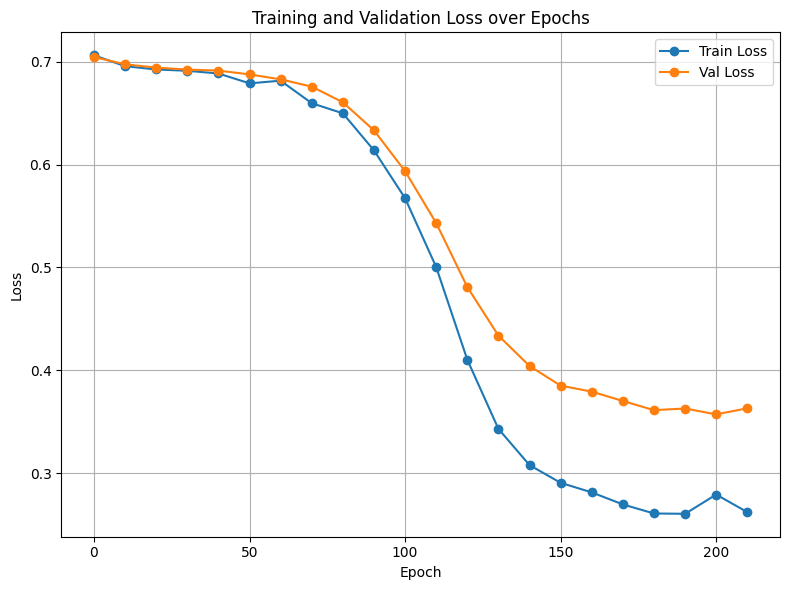

In [52]:
import matplotlib.pyplot as plt

# Training log data as lists
epochs = [0, 10, 20, 30, 40,
          50, 60, 70, 80, 90,
          100, 110, 120, 130, 140,
          150, 160, 170, 180, 190,
          200, 210]
train_losses = [0.7062, 0.6956, 0.6924, 0.6911, 0.6885,
                0.6789, 0.6815, 0.6596, 0.6498, 0.6138,
                0.5673, 0.5004, 0.4104, 0.3432, 0.3080,
                0.2908, 0.2815, 0.2698, 0.2610, 0.2607,
                0.2794, 0.2623]
val_losses = [0.7045, 0.6974, 0.6942, 0.6923, 0.6913,
              0.6876, 0.6828, 0.6757, 0.6605, 0.6332,
              0.5936, 0.5432, 0.4810, 0.4338, 0.4043,
              0.3852, 0.3794, 0.3703, 0.3614, 0.3630,
              0.3573, 0.3632]

plt.figure(figsize=(8,6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


### Hyperparameter Tuning

In [60]:
# hidden_channels = 16
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from itertools import combinations
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# Assumes `clique_structure` is defined externally

# 1. Convert clique structure to graph Data object
unique_nodes = set()
for k, cliques in clique_structure.items():
    for nodes_tuple in cliques.keys():
        for node in nodes_tuple:
            unique_nodes.add(node)

node2idx = {node: i for i, node in enumerate(unique_nodes)}

edge_index_list = []
edge_attr_list = []

def add_edges_from_clique(nodes, attr):
    (u, v) = nodes
    u_idx = node2idx[u]
    v_idx = node2idx[v]
    edge_index_list.append([u_idx, v_idx])
    edge_attr_list.append([attr['urban'], attr['country']])
    # Undirected edge
    edge_index_list.append([v_idx, u_idx])
    edge_attr_list.append([attr['urban'], attr['country']])

for clique_size, cliques in clique_structure.items():
    for nodes, attr in cliques.items():
        add_edges_from_clique(nodes, attr)

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

num_nodes = len(unique_nodes)
x = torch.randn((num_nodes, 16))  # random features as placeholder
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 2. Define models
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class EdgePredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, in_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(in_channels, 1)
        )

    def forward(self, z, edge_index):
        z_u = z[edge_index[0]]
        z_v = z[edge_index[1]]
        out = self.mlp(torch.cat([z_u, z_v], dim=-1))
        return out.view(-1)

# 3. Train/val/test split
all_edges = edge_index.t().tolist()
unique_edges = list(set((min(u,v), max(u,v)) for u,v in all_edges if u!=v))
random.shuffle(unique_edges)

num_train = int(len(unique_edges)*0.8)
num_val = int(len(unique_edges)*0.1)

train_edges = unique_edges[:num_train]
val_edges = unique_edges[num_train:num_train+num_val]
test_edges = unique_edges[num_train+num_val:]

def to_tensor(edges):
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

train_edges = to_tensor(train_edges)
val_edges = to_tensor(val_edges)
test_edges = to_tensor(test_edges)

def negative_sampling(num_samples, num_nodes, existing_set):
    neg_edges = []
    while len(neg_edges) < num_samples:
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if u != v:
            e = (min(u,v), max(u,v))
            if e not in existing_set:
                neg_edges.append([u,v])
                existing_set.add(e)
    return torch.tensor(neg_edges, dtype=torch.long).t().contiguous()

train_set = set((min(a,b), max(a,b)) for a,b in train_edges.t().tolist())
val_set = set((min(a,b), max(a,b)) for a,b in val_edges.t().tolist())
test_set = set((min(a,b), max(a,b)) for a,b in test_edges.t().tolist())

train_neg = negative_sampling(train_edges.size(1), num_nodes, train_set)
val_neg = negative_sampling(val_edges.size(1), num_nodes, val_set)
test_neg = negative_sampling(test_edges.size(1), num_nodes, test_set)

# 4. Training setup with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GNNEncoder(in_channels=16, hidden_channels=16, out_channels=16, dropout=0.5).to(device)
predictor = EdgePredictor(16).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(predictor.parameters()),
    lr=0.001, weight_decay=1e-4
)
criterion = torch.nn.BCEWithLogitsLoss()

data = data.to(device)
train_edges = train_edges.to(device)
val_edges = val_edges.to(device)
test_edges = test_edges.to(device)
train_neg = train_neg.to(device)
val_neg = val_neg.to(device)
test_neg = test_neg.to(device)

def get_loss(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index)
    neg_score = predictor(z, neg_edge_index)
    scores = torch.cat([pos_score, neg_score], dim=0)
    labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))], dim=0).to(device)
    return criterion(scores, labels)

def get_metrics(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index).sigmoid().detach().cpu().numpy()
    neg_score = predictor(z, neg_edge_index).sigmoid().detach().cpu().numpy()
    scores = list(pos_score) + list(neg_score)
    labels = [1]*len(pos_score) + [0]*len(neg_score)
    auc = roc_auc_score(labels, scores)
    # Accuracy at threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

best_val_loss = float('inf')
patience_counter = 0
patience = 20
max_epochs = 500

for epoch in range(max_epochs):
    encoder.train()
    predictor.train()
    optimizer.zero_grad()
    z = encoder(data.x, data.edge_index)
    loss = get_loss(z, predictor, train_edges, train_neg)
    loss.backward()
    optimizer.step()

    encoder.eval()
    predictor.eval()
    with torch.no_grad():
        z = encoder(data.x, data.edge_index)
        val_loss = get_loss(z, predictor, val_edges, val_neg).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_encoder_weights = encoder.state_dict()
        best_predictor_weights = predictor.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.4f}, Val Loss {val_loss:.4f}")

# Load best weights
encoder.load_state_dict(best_encoder_weights)
predictor.load_state_dict(best_predictor_weights)
encoder.eval()
predictor.eval()

with torch.no_grad():
    z = encoder(data.x, data.edge_index)
    test_auc, test_acc = get_metrics(z, predictor, test_edges, test_neg)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 0: Train Loss 0.6966, Val Loss 0.6969
Epoch 10: Train Loss 0.6943, Val Loss 0.6917
Epoch 20: Train Loss 0.6904, Val Loss 0.6879
Epoch 30: Train Loss 0.6872, Val Loss 0.6843
Epoch 40: Train Loss 0.6810, Val Loss 0.6798
Epoch 50: Train Loss 0.6749, Val Loss 0.6727
Epoch 60: Train Loss 0.6600, Val Loss 0.6620
Epoch 70: Train Loss 0.6282, Val Loss 0.6445
Epoch 80: Train Loss 0.5942, Val Loss 0.6241
Epoch 90: Train Loss 0.5444, Val Loss 0.6017
Epoch 100: Train Loss 0.5062, Val Loss 0.5854
Epoch 110: Train Loss 0.4093, Val Loss 0.5931
Epoch 120: Train Loss 0.3506, Val Loss 0.6322
Early stopping triggered
Test AUC: 0.7500
Test Accuracy: 0.7500


In [62]:
# hidden_channels = 64
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from itertools import combinations
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# Assumes `clique_structure` is defined externally

# 1. Convert clique structure to graph Data object
unique_nodes = set()
for k, cliques in clique_structure.items():
    for nodes_tuple in cliques.keys():
        for node in nodes_tuple:
            unique_nodes.add(node)

node2idx = {node: i for i, node in enumerate(unique_nodes)}

edge_index_list = []
edge_attr_list = []

def add_edges_from_clique(nodes, attr):
    (u, v) = nodes
    u_idx = node2idx[u]
    v_idx = node2idx[v]
    edge_index_list.append([u_idx, v_idx])
    edge_attr_list.append([attr['urban'], attr['country']])
    # Undirected edge
    edge_index_list.append([v_idx, u_idx])
    edge_attr_list.append([attr['urban'], attr['country']])

for clique_size, cliques in clique_structure.items():
    for nodes, attr in cliques.items():
        add_edges_from_clique(nodes, attr)

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

num_nodes = len(unique_nodes)
x = torch.randn((num_nodes, 16))  # random features as placeholder
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 2. Define models
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class EdgePredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, in_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(in_channels, 1)
        )

    def forward(self, z, edge_index):
        z_u = z[edge_index[0]]
        z_v = z[edge_index[1]]
        out = self.mlp(torch.cat([z_u, z_v], dim=-1))
        return out.view(-1)

# 3. Train/val/test split
all_edges = edge_index.t().tolist()
unique_edges = list(set((min(u,v), max(u,v)) for u,v in all_edges if u!=v))
random.shuffle(unique_edges)

num_train = int(len(unique_edges)*0.8)
num_val = int(len(unique_edges)*0.1)

train_edges = unique_edges[:num_train]
val_edges = unique_edges[num_train:num_train+num_val]
test_edges = unique_edges[num_train+num_val:]

def to_tensor(edges):
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

train_edges = to_tensor(train_edges)
val_edges = to_tensor(val_edges)
test_edges = to_tensor(test_edges)

def negative_sampling(num_samples, num_nodes, existing_set):
    neg_edges = []
    while len(neg_edges) < num_samples:
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if u != v:
            e = (min(u,v), max(u,v))
            if e not in existing_set:
                neg_edges.append([u,v])
                existing_set.add(e)
    return torch.tensor(neg_edges, dtype=torch.long).t().contiguous()

train_set = set((min(a,b), max(a,b)) for a,b in train_edges.t().tolist())
val_set = set((min(a,b), max(a,b)) for a,b in val_edges.t().tolist())
test_set = set((min(a,b), max(a,b)) for a,b in test_edges.t().tolist())

train_neg = negative_sampling(train_edges.size(1), num_nodes, train_set)
val_neg = negative_sampling(val_edges.size(1), num_nodes, val_set)
test_neg = negative_sampling(test_edges.size(1), num_nodes, test_set)

# 4. Training setup with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GNNEncoder(in_channels=16, hidden_channels=64, out_channels=16, dropout=0.5).to(device)
predictor = EdgePredictor(16).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(predictor.parameters()),
    lr=0.001, weight_decay=1e-4
)
criterion = torch.nn.BCEWithLogitsLoss()

data = data.to(device)
train_edges = train_edges.to(device)
val_edges = val_edges.to(device)
test_edges = test_edges.to(device)
train_neg = train_neg.to(device)
val_neg = val_neg.to(device)
test_neg = test_neg.to(device)

def get_loss(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index)
    neg_score = predictor(z, neg_edge_index)
    scores = torch.cat([pos_score, neg_score], dim=0)
    labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))], dim=0).to(device)
    return criterion(scores, labels)

def get_metrics(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index).sigmoid().detach().cpu().numpy()
    neg_score = predictor(z, neg_edge_index).sigmoid().detach().cpu().numpy()
    scores = list(pos_score) + list(neg_score)
    labels = [1]*len(pos_score) + [0]*len(neg_score)
    auc = roc_auc_score(labels, scores)
    # Accuracy at threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

best_val_loss = float('inf')
patience_counter = 0
patience = 20
max_epochs = 500

for epoch in range(max_epochs):
    encoder.train()
    predictor.train()
    optimizer.zero_grad()
    z = encoder(data.x, data.edge_index)
    loss = get_loss(z, predictor, train_edges, train_neg)
    loss.backward()
    optimizer.step()

    encoder.eval()
    predictor.eval()
    with torch.no_grad():
        z = encoder(data.x, data.edge_index)
        val_loss = get_loss(z, predictor, val_edges, val_neg).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_encoder_weights = encoder.state_dict()
        best_predictor_weights = predictor.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.4f}, Val Loss {val_loss:.4f}")

# Load best weights
encoder.load_state_dict(best_encoder_weights)
predictor.load_state_dict(best_predictor_weights)
encoder.eval()
predictor.eval()

with torch.no_grad():
    z = encoder(data.x, data.edge_index)
    test_auc, test_acc = get_metrics(z, predictor, test_edges, test_neg)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 0: Train Loss 0.6959, Val Loss 0.7023
Epoch 10: Train Loss 0.6876, Val Loss 0.6954
Epoch 20: Train Loss 0.6840, Val Loss 0.6919
Epoch 30: Train Loss 0.6701, Val Loss 0.6829
Epoch 40: Train Loss 0.6430, Val Loss 0.6721
Epoch 50: Train Loss 0.6103, Val Loss 0.6542
Epoch 60: Train Loss 0.5570, Val Loss 0.6324
Epoch 70: Train Loss 0.4424, Val Loss 0.6181
Epoch 80: Train Loss 0.3540, Val Loss 0.6638
Early stopping triggered
Test AUC: 0.7812
Test Accuracy: 0.8125


In [63]:
# hidden_channels = 128
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from itertools import combinations
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# Assumes `clique_structure` is defined externally

# 1. Convert clique structure to graph Data object
unique_nodes = set()
for k, cliques in clique_structure.items():
    for nodes_tuple in cliques.keys():
        for node in nodes_tuple:
            unique_nodes.add(node)

node2idx = {node: i for i, node in enumerate(unique_nodes)}

edge_index_list = []
edge_attr_list = []

def add_edges_from_clique(nodes, attr):
    (u, v) = nodes
    u_idx = node2idx[u]
    v_idx = node2idx[v]
    edge_index_list.append([u_idx, v_idx])
    edge_attr_list.append([attr['urban'], attr['country']])
    # Undirected edge
    edge_index_list.append([v_idx, u_idx])
    edge_attr_list.append([attr['urban'], attr['country']])

for clique_size, cliques in clique_structure.items():
    for nodes, attr in cliques.items():
        add_edges_from_clique(nodes, attr)

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

num_nodes = len(unique_nodes)
x = torch.randn((num_nodes, 16))  # random features as placeholder
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 2. Define models
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class EdgePredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, in_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(in_channels, 1)
        )

    def forward(self, z, edge_index):
        z_u = z[edge_index[0]]
        z_v = z[edge_index[1]]
        out = self.mlp(torch.cat([z_u, z_v], dim=-1))
        return out.view(-1)

# 3. Train/val/test split
all_edges = edge_index.t().tolist()
unique_edges = list(set((min(u,v), max(u,v)) for u,v in all_edges if u!=v))
random.shuffle(unique_edges)

num_train = int(len(unique_edges)*0.8)
num_val = int(len(unique_edges)*0.1)

train_edges = unique_edges[:num_train]
val_edges = unique_edges[num_train:num_train+num_val]
test_edges = unique_edges[num_train+num_val:]

def to_tensor(edges):
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

train_edges = to_tensor(train_edges)
val_edges = to_tensor(val_edges)
test_edges = to_tensor(test_edges)

def negative_sampling(num_samples, num_nodes, existing_set):
    neg_edges = []
    while len(neg_edges) < num_samples:
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if u != v:
            e = (min(u,v), max(u,v))
            if e not in existing_set:
                neg_edges.append([u,v])
                existing_set.add(e)
    return torch.tensor(neg_edges, dtype=torch.long).t().contiguous()

train_set = set((min(a,b), max(a,b)) for a,b in train_edges.t().tolist())
val_set = set((min(a,b), max(a,b)) for a,b in val_edges.t().tolist())
test_set = set((min(a,b), max(a,b)) for a,b in test_edges.t().tolist())

train_neg = negative_sampling(train_edges.size(1), num_nodes, train_set)
val_neg = negative_sampling(val_edges.size(1), num_nodes, val_set)
test_neg = negative_sampling(test_edges.size(1), num_nodes, test_set)

# 4. Training setup with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GNNEncoder(in_channels=16, hidden_channels=128, out_channels=16, dropout=0.5).to(device)
predictor = EdgePredictor(16).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(predictor.parameters()),
    lr=0.001, weight_decay=1e-4
)
criterion = torch.nn.BCEWithLogitsLoss()

data = data.to(device)
train_edges = train_edges.to(device)
val_edges = val_edges.to(device)
test_edges = test_edges.to(device)
train_neg = train_neg.to(device)
val_neg = val_neg.to(device)
test_neg = test_neg.to(device)

def get_loss(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index)
    neg_score = predictor(z, neg_edge_index)
    scores = torch.cat([pos_score, neg_score], dim=0)
    labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))], dim=0).to(device)
    return criterion(scores, labels)

def get_metrics(z, predictor, pos_edge_index, neg_edge_index):
    pos_score = predictor(z, pos_edge_index).sigmoid().detach().cpu().numpy()
    neg_score = predictor(z, neg_edge_index).sigmoid().detach().cpu().numpy()
    scores = list(pos_score) + list(neg_score)
    labels = [1]*len(pos_score) + [0]*len(neg_score)
    auc = roc_auc_score(labels, scores)
    # Accuracy at threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

best_val_loss = float('inf')
patience_counter = 0
patience = 20
max_epochs = 500

for epoch in range(max_epochs):
    encoder.train()
    predictor.train()
    optimizer.zero_grad()
    z = encoder(data.x, data.edge_index)
    loss = get_loss(z, predictor, train_edges, train_neg)
    loss.backward()
    optimizer.step()

    encoder.eval()
    predictor.eval()
    with torch.no_grad():
        z = encoder(data.x, data.edge_index)
        val_loss = get_loss(z, predictor, val_edges, val_neg).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_encoder_weights = encoder.state_dict()
        best_predictor_weights = predictor.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.4f}, Val Loss {val_loss:.4f}")

# Load best weights
encoder.load_state_dict(best_encoder_weights)
predictor.load_state_dict(best_predictor_weights)
encoder.eval()
predictor.eval()

with torch.no_grad():
    z = encoder(data.x, data.edge_index)
    test_auc, test_acc = get_metrics(z, predictor, test_edges, test_neg)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 0: Train Loss 0.6961, Val Loss 0.6957
Epoch 10: Train Loss 0.6892, Val Loss 0.6896
Epoch 20: Train Loss 0.6839, Val Loss 0.6829
Epoch 30: Train Loss 0.6700, Val Loss 0.6735
Epoch 40: Train Loss 0.6502, Val Loss 0.6573
Epoch 50: Train Loss 0.6108, Val Loss 0.6298
Epoch 60: Train Loss 0.5502, Val Loss 0.5998
Epoch 70: Train Loss 0.4670, Val Loss 0.5903
Epoch 80: Train Loss 0.4164, Val Loss 0.6209
Early stopping triggered
Test AUC: 0.8750
Test Accuracy: 0.7500


In [65]:
(0.7344+0.9375+0.8906)/3

0.8541666666666666

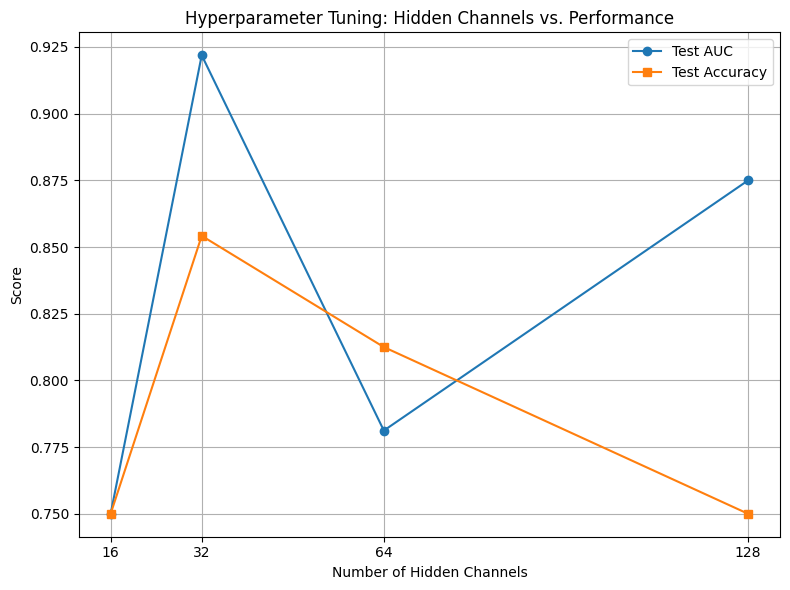

In [70]:
# Plot a graph for hyperparameter tuning
# num_hidden_channels = [16, 32, 64, 128]
# test_auc = [0.7500, (0.9375+0.9375+0.8906)/3, 0.7812, 0.8750]
# tesc_acc = [0.7500, (0.8125+0.9375+0.8125)/3, 0.8125, 0.7500]
import matplotlib.pyplot as plt

num_hidden_channels = [16, 32, 64, 128]

# Compute the averaged values:
# (0.9375 + 0.9375 + 0.8906) / 3 = 2.7656 / 3 ≈ 0.9219
test_auc = [0.7500, 0.9219, 0.7812, 0.8750]

# (0.8125 + 0.9375 + 0.8125) / 3 = 2.5625 / 3 ≈ 0.8542
test_acc = [0.7500, 0.8542, 0.8125, 0.7500]

plt.figure(figsize=(8,6))
plt.plot(num_hidden_channels, test_auc, marker='o', label='Test AUC')
plt.plot(num_hidden_channels, test_acc, marker='s', label='Test Accuracy')

plt.title('Hyperparameter Tuning: Hidden Channels vs. Performance')
plt.xlabel('Number of Hidden Channels')
plt.ylabel('Score')
plt.xticks(num_hidden_channels)  # Set ticks only at [16, 32, 64, 128]
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### Baseline

In [72]:
import torch
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# ----------------------------------
# Assume you have the following already prepared:
# data: A PyTorch Geometric Data object containing node features and edge_index
# train_edges, val_edges, test_edges: Tensors of shape [2, num_edges] representing positive edges for train/val/test
# train_neg, val_neg, test_neg: Tensors of shape [2, num_edges] representing negative (non-existent) edges

# This setup was demonstrated in previous code snippets. For this example, we assume they are ready.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# ----------------------------------
# Define a function to evaluate random predictions
def evaluate_random_predictions(pos_edge_index, neg_edge_index):
    # Number of edges to predict
    num_pos = pos_edge_index.size(1)
    num_neg = neg_edge_index.size(1)

    # Generate random scores between 0 and 1 for each edge (positive and negative)
    # These scores represent the predicted probability of an edge existing.
    pos_scores = torch.rand(num_pos)
    neg_scores = torch.rand(num_neg)

    # Convert to numpy for metric calculation
    pos_scores_np = pos_scores.cpu().numpy()
    neg_scores_np = neg_scores.cpu().numpy()

    scores = list(pos_scores_np) + list(neg_scores_np)
    labels = [1]*num_pos + [0]*num_neg

    # Compute AUC
    auc = roc_auc_score(labels, scores)

    # Compute accuracy with threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

# ----------------------------------
# "Train" the baseline model
# There's nothing to train here, as our baseline is just random guesses.
# In a real scenario, you might just skip this part.

print("No training step for the baseline. Just random guesses.")

# ----------------------------------
# Validation (if needed, to mimic the pipeline)
val_auc, val_acc = evaluate_random_predictions(val_edges, val_neg)
print(f"Validation AUC: {val_auc:.4f}, Validation Accuracy: {val_acc:.4f}")

# Early stopping doesn't apply here since there's no training and no improvement to track.
# This is purely a baseline.

# ----------------------------------
# Test Evaluation
test_auc, test_acc = evaluate_random_predictions(test_edges, test_neg)
print("Baseline Model (Random Guessing) Performance on Test Set:")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# This gives you a baseline metric (AUC and Accuracy) to compare your complex models against.
# Any model should ideally outperform this random baseline.


No training step for the baseline. Just random guesses.
Validation AUC: 0.4286, Validation Accuracy: 0.4286
Baseline Model (Random Guessing) Performance on Test Set:
Test AUC: 0.5156
Test Accuracy: 0.6250


In [73]:
import torch
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# ----------------------------------
# Assume you have the following already prepared:
# data: A PyTorch Geometric Data object containing node features and edge_index
# train_edges, val_edges, test_edges: Tensors of shape [2, num_edges] representing positive edges for train/val/test
# train_neg, val_neg, test_neg: Tensors of shape [2, num_edges] representing negative (non-existent) edges

# This setup was demonstrated in previous code snippets. For this example, we assume they are ready.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# ----------------------------------
# Define a function to evaluate random predictions
def evaluate_random_predictions(pos_edge_index, neg_edge_index):
    # Number of edges to predict
    num_pos = pos_edge_index.size(1)
    num_neg = neg_edge_index.size(1)

    # Generate random scores between 0 and 1 for each edge (positive and negative)
    # These scores represent the predicted probability of an edge existing.
    pos_scores = torch.rand(num_pos)
    neg_scores = torch.rand(num_neg)

    # Convert to numpy for metric calculation
    pos_scores_np = pos_scores.cpu().numpy()
    neg_scores_np = neg_scores.cpu().numpy()

    scores = list(pos_scores_np) + list(neg_scores_np)
    labels = [1]*num_pos + [0]*num_neg

    # Compute AUC
    auc = roc_auc_score(labels, scores)

    # Compute accuracy with threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

# ----------------------------------
# "Train" the baseline model
# There's nothing to train here, as our baseline is just random guesses.
# In a real scenario, you might just skip this part.

print("No training step for the baseline. Just random guesses.")

# ----------------------------------
# Validation (if needed, to mimic the pipeline)
val_auc, val_acc = evaluate_random_predictions(val_edges, val_neg)
print(f"Validation AUC: {val_auc:.4f}, Validation Accuracy: {val_acc:.4f}")

# Early stopping doesn't apply here since there's no training and no improvement to track.
# This is purely a baseline.

# ----------------------------------
# Test Evaluation
test_auc, test_acc = evaluate_random_predictions(test_edges, test_neg)
print("Baseline Model (Random Guessing) Performance on Test Set:")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# This gives you a baseline metric (AUC and Accuracy) to compare your complex models against.
# Any model should ideally outperform this random baseline.


No training step for the baseline. Just random guesses.
Validation AUC: 0.6939, Validation Accuracy: 0.6429
Baseline Model (Random Guessing) Performance on Test Set:
Test AUC: 0.5469
Test Accuracy: 0.5000


In [74]:
import torch
import random
from sklearn.metrics import roc_auc_score, accuracy_score

# ----------------------------------
# Assume you have the following already prepared:
# data: A PyTorch Geometric Data object containing node features and edge_index
# train_edges, val_edges, test_edges: Tensors of shape [2, num_edges] representing positive edges for train/val/test
# train_neg, val_neg, test_neg: Tensors of shape [2, num_edges] representing negative (non-existent) edges

# This setup was demonstrated in previous code snippets. For this example, we assume they are ready.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# ----------------------------------
# Define a function to evaluate random predictions
def evaluate_random_predictions(pos_edge_index, neg_edge_index):
    # Number of edges to predict
    num_pos = pos_edge_index.size(1)
    num_neg = neg_edge_index.size(1)

    # Generate random scores between 0 and 1 for each edge (positive and negative)
    # These scores represent the predicted probability of an edge existing.
    pos_scores = torch.rand(num_pos)
    neg_scores = torch.rand(num_neg)

    # Convert to numpy for metric calculation
    pos_scores_np = pos_scores.cpu().numpy()
    neg_scores_np = neg_scores.cpu().numpy()

    scores = list(pos_scores_np) + list(neg_scores_np)
    labels = [1]*num_pos + [0]*num_neg

    # Compute AUC
    auc = roc_auc_score(labels, scores)

    # Compute accuracy with threshold 0.5
    preds = [1 if s > 0.5 else 0 for s in scores]
    acc = accuracy_score(labels, preds)
    return auc, acc

# ----------------------------------
# "Train" the baseline model
# There's nothing to train here, as our baseline is just random guesses.
# In a real scenario, you might just skip this part.

print("No training step for the baseline. Just random guesses.")

# ----------------------------------
# Validation (if needed, to mimic the pipeline)
val_auc, val_acc = evaluate_random_predictions(val_edges, val_neg)
print(f"Validation AUC: {val_auc:.4f}, Validation Accuracy: {val_acc:.4f}")

# Early stopping doesn't apply here since there's no training and no improvement to track.
# This is purely a baseline.

# ----------------------------------
# Test Evaluation
test_auc, test_acc = evaluate_random_predictions(test_edges, test_neg)
print("Baseline Model (Random Guessing) Performance on Test Set:")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# This gives you a baseline metric (AUC and Accuracy) to compare your complex models against.
# Any model should ideally outperform this random baseline.


No training step for the baseline. Just random guesses.
Validation AUC: 0.7551, Validation Accuracy: 0.7857
Baseline Model (Random Guessing) Performance on Test Set:
Test AUC: 0.2344
Test Accuracy: 0.3125
